In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
import numpy as np
import matplotlib


In [6]:
def process(datasets, dtype='big', output_fname: str = 'Nen'):
    
    fig, ax = plt.subplots(nrows=1, ncols=len(datasets), figsize=(10 * len(datasets), 10), squeeze=False)
    
    results = []
    results_plotted = []
    
    for index, dataset in enumerate(datasets):
        values = []

        for fname in glob.glob(f'{dataset}/*.csv'):
            print(fname)
            df = pd.read_csv(fname)
            values.append(df)
            
        if dataset == 'MouseAtlas':
            concated = pd.read_csv('./MouseAtlas/clustering/concated.csv')
        elif dataset == 'BreastTumor':
            concated = pd.read_csv('concated_breasttumor.csv')
        else:
            concated = pd.concat(values)
        
        concated['dtype'] = dataset_mapping[dataset]
        concated['cell_dtype'] = dataset_cell_mapping[dataset]
        concated['clustering_type'] = clustering_method[dataset]
        results.append(concated)
        
        concated['rank'] = concated.groupby('Metric')['vals'].rank(method="dense", ascending=False)
        distance = concated[concated.Metric.str.contains('distance')]
        distance_order = distance.groupby('method').mean('vals')
        distance_order.columns = ['mean_val_distance', 'mean_rank_distance']
        not_distance = concated[~concated.Metric.str.contains('distance')]
        not_distance_order = not_distance.groupby('method').mean('vals')
        not_distance_order.columns = ['mean_val_not_distance', 'mean_rank_not_distance']
        result = distance_order.join(not_distance_order)
        
        print(result.head())
        print(result.index)
        plot = sns.scatterplot(
            data=result,
            x='mean_val_distance',
            y='mean_val_not_distance',
            hue=result.index,
            ax=ax[0, index],
            s=200,
            hue_order=['threshold', 'cicero', 'boruta', 'scopen_threshold',  'scopen_cicero', 'scopen_boruta', 'scale_threshold', 'scale_cicero', 'scale_boruta']
        )

        plot.set_title(named_titles[dataset], fontsize=30)
        plot.set_xlabel(f'Mean Distance Score', fontsize=30)
        plot.set_ylabel(f'Mean Label Score', fontsize=30)
        plot.set_ylim(0.4, 0.7)
        plot.set_xlim(-0.2, 0.3)
        plot.legend(fontsize=15, markerscale=2, loc='upper left')
        ax[0, index].tick_params(labelsize=40)


        ax[0, index].tick_params(labelsize=20)
        result['dataset'] = dataset
#         result['peak_count'] = peak_count[dataset]
        result['clustering_type'] = clustering_method[dataset]
        results_plotted.append(result)
        
    plt.savefig(output_fname, bbox_inches='tight')
    return pd.concat(results), pd.concat(results_plotted)

# Clustering Analysis

In [10]:
dataset_mapping = {
    '../../Datasets/GSE96769/TopMetrics': 'big',
    '../../Datasets/GSE96769/TopMetricsFull': 'big',
}

dataset_cell_mapping = {
    '../../Datasets/GSE96769/TopMetrics': 'small',
    '../../Datasets/GSE96769/TopMetricsFull': 'small',
}

named_titles = {
    '../../Datasets/GSE96769/TopMetrics': 'Clustering 150 PCA',
    '../../Datasets/GSE96769/TopMetricsFull': 'Clustering Full features'
}

peak_count = {
    '../../Datasets/GSE96769/TopMetrics': 230000,
    '../../Datasets/GSE96769/TopMetricsFull': 230000,
}

clustering_method = {
    '../../Datasets/GSE96769/TopMetrics': '150',
    '../../Datasets/GSE96769/TopMetricsFull': 'all'
}

../../Datasets/GSE96769/TopMetrics/TopScaleboruta.csv
../../Datasets/GSE96769/TopMetrics/TopScopenthreshold.csv
../../Datasets/GSE96769/TopMetrics/cicero.csv
../../Datasets/GSE96769/TopMetrics/threshold.csv
../../Datasets/GSE96769/TopMetrics/TopScopenboruta.csv
../../Datasets/GSE96769/TopMetrics/TopScalecicero.csv
../../Datasets/GSE96769/TopMetrics/TopScalethreshold.csv
../../Datasets/GSE96769/TopMetrics/boruta.csv
../../Datasets/GSE96769/TopMetrics/TopScopencicero.csv
                 mean_val_distance  mean_rank_distance  mean_val_not_distance  \
method                                                                          
boruta                    0.176709            3.333333               0.637451   
cicero                    0.153646            4.666667               0.609477   
scale_boruta              0.213293            1.333333               0.632344   
scale_cicero              0.158789            4.333333               0.593298   
scale_threshold           0.074934      

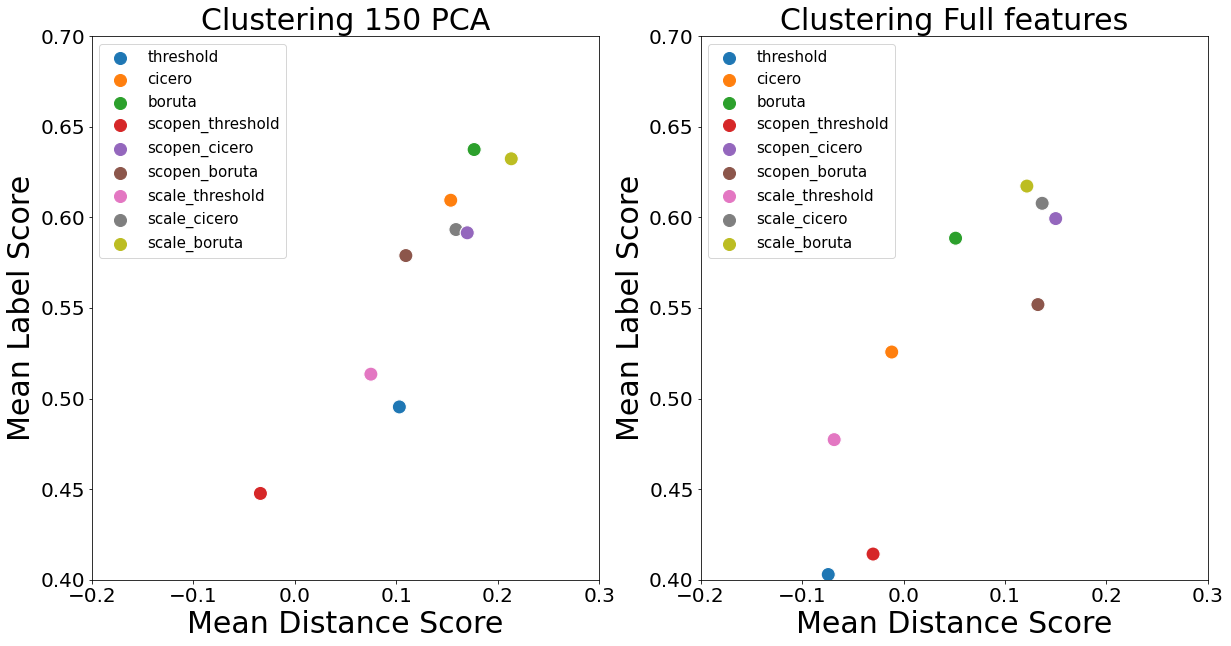

In [14]:
result, results_plotted = process(dataset_mapping, output_fname='../assets/ClusteringScatterPlot150vsAll.jpeg')

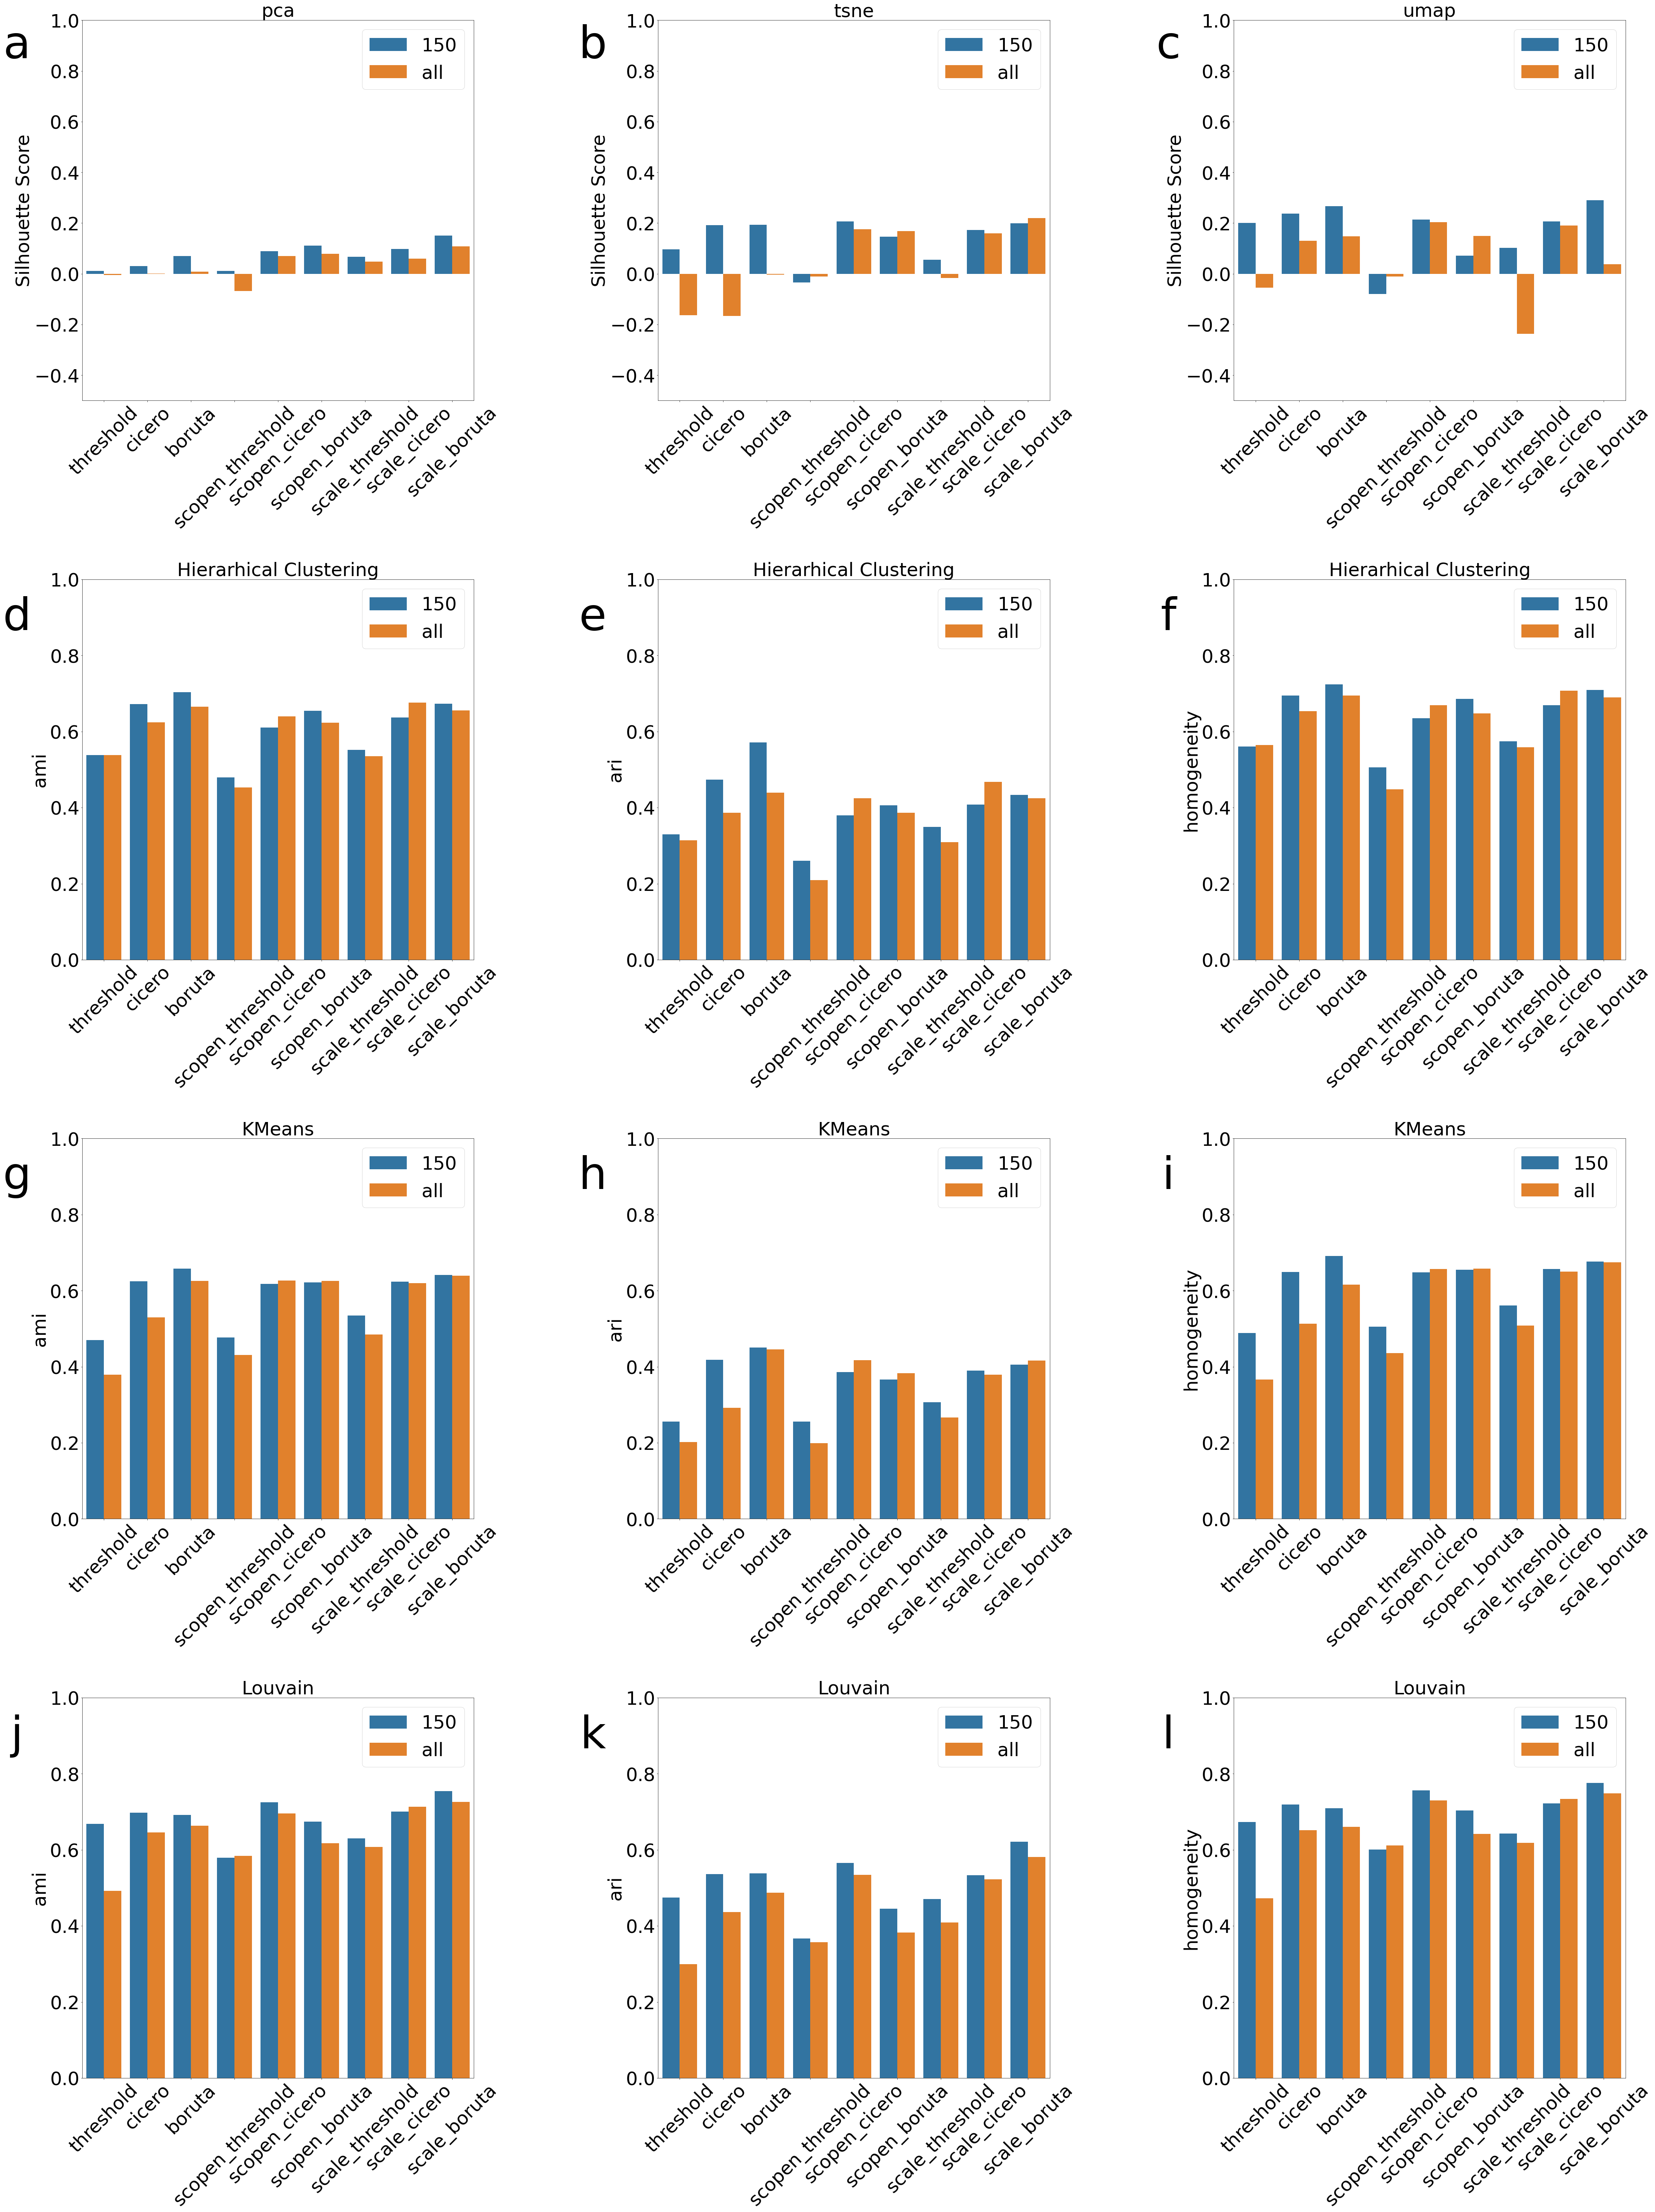

In [16]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20 * 3, 20 * 4))


mapping = ['Silhouette Score', 'Hierarhical Clustering', 'KMeans', 'Louvain']
for index, metric in enumerate(sorted(result.Metric.unique())):
    
    col = index % 3
    row = index // 3
    
    
    subset_df = result[result.Metric == metric]
    
    plot = sns.barplot(
        data=subset_df, y='vals', x='method',
        hue='clustering_type',
        ax=ax[row, col],
        order=['threshold', 'cicero', 'boruta', 'scopen_threshold',  'scopen_cicero', 'scopen_boruta', 'scale_threshold', 'scale_cicero', 'scale_boruta'],
        hue_order=['150', 'all'],
    
    )
    
    if metric.startswith('distance'):
        metric = metric.replace('distance', 'silhouette')
    
    letter = chr(ord('a') + index)
    plot.text(-2, 0.9, letter, 
       fontsize = 120,          # Size
       color = "black",          # Color
       ha = "center", # Horizontal alignment
       va = "center")
    
    plot.set_xlabel(f'', fontsize=50)
    if row >= 1:
        plot.set_ylim((0.0, 1.0))
    else:
        plot.set_ylim((-0.5, 1.0))
    
    if row == 0:
        plot.set_title(f'{metric.split("_", 1)[1]}', fontsize=50)
        plot.set_ylabel(mapping[row], fontsize=50)
    else:
        plot.set_ylabel(f'{metric.split("_", 1)[1]}', fontsize=50)
        plot.set_title(mapping[row], fontsize=50)
        
    
    current_ax = ax[row, col]
    current_ax.set_xticklabels(current_ax.get_xticklabels(),rotation=45)
    ax[row, col].tick_params(labelsize=50)
    plot.legend(fontsize=50)

plt.subplots_adjust(left=0.02,
                bottom=0.02,
                right=0.98,
                top=0.98,
                wspace=0.47,
                hspace=0.47)

    

# ax.tick_params(labelsize=40)
plt.savefig(f'../assets/ByMetricFullVsNotFull.jpeg', bbox_inches='tight')

# Processing results

In [77]:
dataset_cell_mapping = {
    'GSE96769_TF': 'big',
    'FibroCard': 'big',
    'TCells': 'small',
    'CellLines': 'small',
    'PBMC5K': 'big',
    'HSC_clustering': 'small',
    'MouseAtlas': 'big',
    'Forebrain': 'small',
    'BreastTumor': 'small'
}

dataset_mapping = {
    'GSE96769_TF': 'big',
    'HSC_clustering': 'big',
    'FibroCard': 'small',
    'TCells': 'small',
    'CellLines': 'big',
    'PBMC5K': 'big',
    'HSC_clustering': 'big',
    'MouseAtlas': 'big',
    'Forebrain': 'small',
    'BreastTumor': 'small'
}

named_titles = {
    'GSE96769_TF': 'TF-limited Clustering Score',
    'HSC_clustering': 'Complete Clustering Scores',
    'TCells': 'small',
    'CellLines': 'small',
    'PBMC5K': 'big',
    'HSC_clustering': 'small',
    'MouseAtlas': 'Mouse Atlas',
    'Forebrain': 'small',
    'FibroCard': 'FibroCard',
}

named_titles = {
    'GSE96769_TF': 'TF-limited Clustering Score',
    'HSC_clustering': 'HSC',
    'TCells': 'TCells',
    'CellLines': 'CellLines',
    'PBMC5K': 'PBMC5K',
    'HSC_clustering': 'HSC',
    'MouseAtlas': 'Mouse Atlas',
    'Forebrain': 'Forebrain',
    'FibroCard': 'FibroCard',
    'BreastTumor': 'BreastTumor'
}

clustering_method = {
    'CellLines': '150',
    'TCells': '150',
    'Forebrain': '150',
    'BreastTumor': '150',
    'GSE96769_TF': '150',
    'HSC_clustering': '150',
    'FibroCard': '150',
    'PBMC5K': '150',
}

CellLines/TopScaleboruta.csv
CellLines/TopScopenthreshold.csv
CellLines/cicero.csv
CellLines/threshold.csv
CellLines/TopScopenboruta.csv
CellLines/TopScalecicero.csv
CellLines/TopScalethreshold.csv
CellLines/boruta.csv
CellLines/TopScopencicero.csv
                 mean_val_distance  mean_rank_distance  mean_val_not_distance  \
method                                                                          
boruta                    0.408572            6.333333               0.662315   
cicero                    0.457701            4.666667               0.679668   
scale_boruta              0.550459            3.666667               0.854092   
scale_cicero              0.590258            2.000000               0.863495   
scale_threshold           0.510723            5.333333               0.835640   

                 mean_rank_not_distance  
method                                   
boruta                         7.333333  
cicero                         7.222222  
scale_boruta   

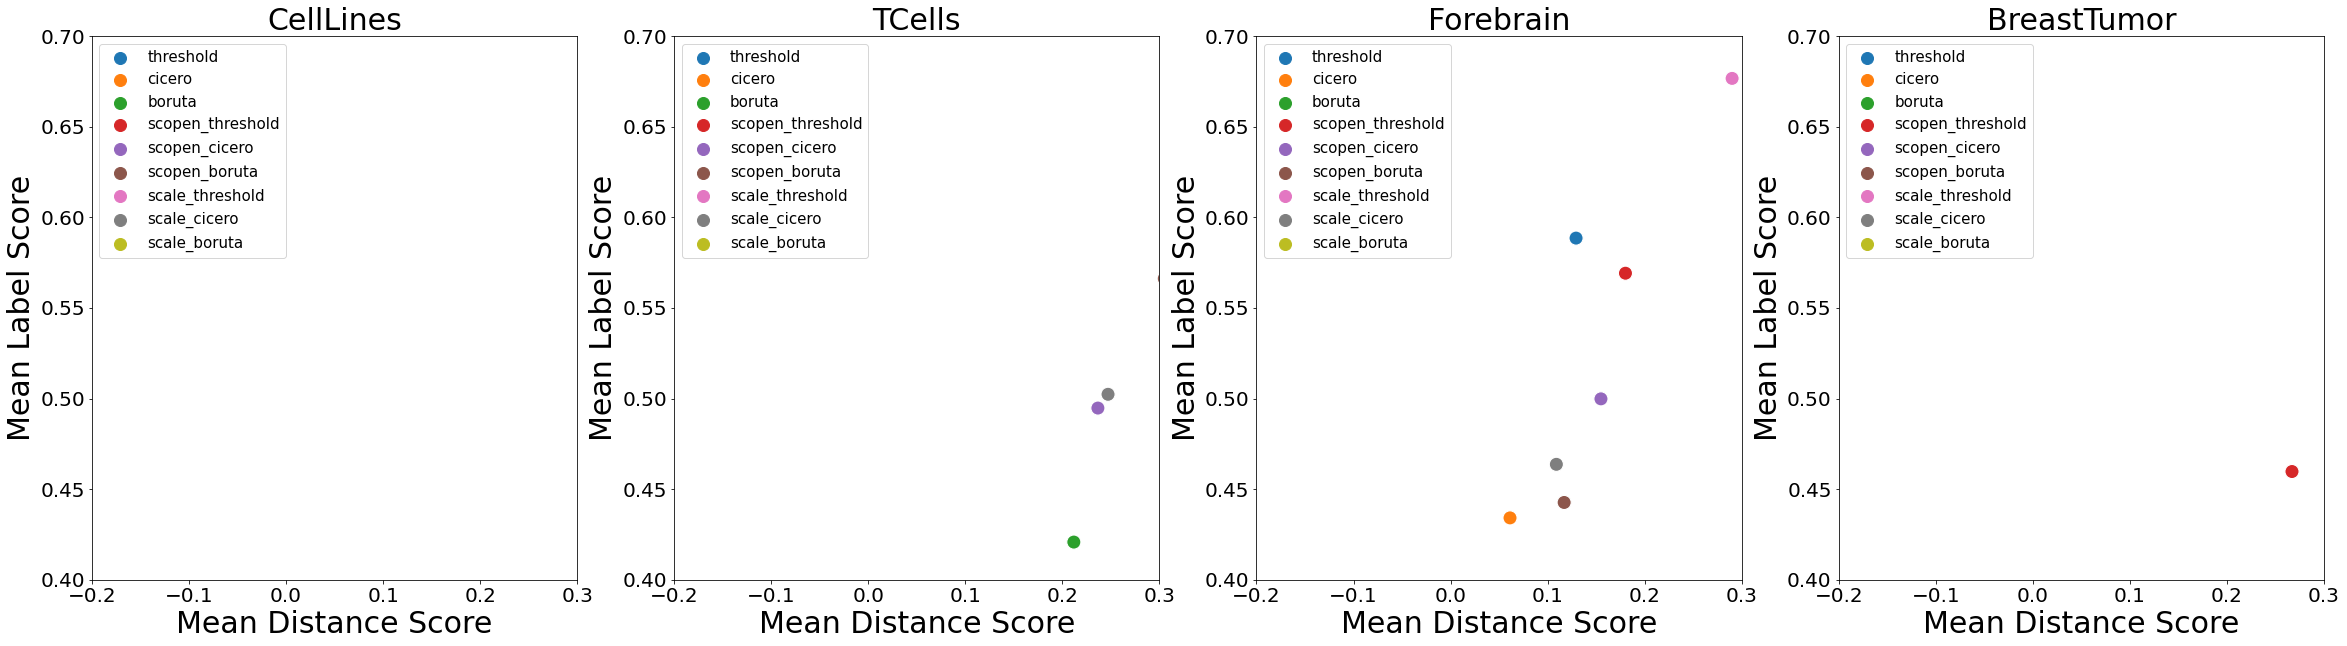

In [78]:
result, _ = process({
    'CellLines': 'small',
    'TCells': 'small',
    'Forebrain': 'small',
    'BreastTumor': 'small'
}, dtype='small', output_fname='assets/output_results_small_correction.jpeg')

GSE96769_TF/scale_cicero.csv
GSE96769_TF/cicero.csv
GSE96769_TF/threshold.csv
GSE96769_TF/scale_threshold.csv
GSE96769_TF/scale_boruta.csv
GSE96769_TF/boruta.csv
GSE96769_TF/scopen_cicero.csv
GSE96769_TF/scopen_boruta.csv
GSE96769_TF/scopen_threshold.csv
                 mean_val_distance  mean_rank_distance  mean_val_not_distance  \
method                                                                          
boruta                    0.000237            6.666667               0.501462   
cicero                    0.086426            3.666667               0.492478   
scale_boruta              0.049492            4.000000               0.570519   
scale_cicero              0.058527            5.000000               0.515535   
scale_threshold           0.023246            6.333333               0.477567   

                 mean_rank_not_distance  
method                                   
boruta                         5.333333  
cicero                         5.444444  
scale_bor

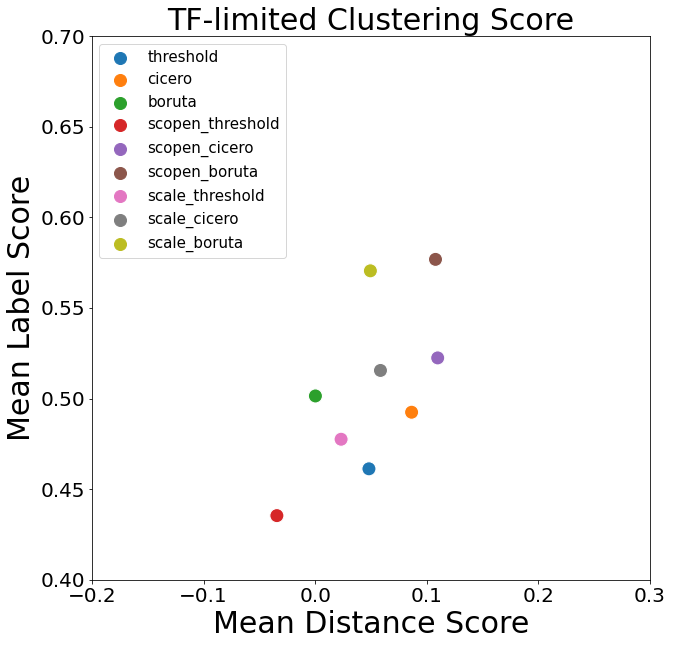

In [79]:
all_df, df_plotted = process({
    'GSE96769_TF': 'big'
}, output_fname='GSE96769_TF.jpeg')

HSC_clustering/TopScaleThreshold.csv
HSC_clustering/TopScaleCicero.csv
HSC_clustering/Threshold.csv
HSC_clustering/Cicero.csv
HSC_clustering/TopScopenCicero.csv
HSC_clustering/TopScopenBoruta.csv
HSC_clustering/TopScopenThreshold.csv
HSC_clustering/TopScaleBoruta.csv
HSC_clustering/Boruta.csv
                 mean_val_distance  mean_rank_distance  mean_val_not_distance  \
method                                                                          
boruta                    0.176709            3.333333               0.637451   
cicero                    0.153646            4.666667               0.609477   
scale_boruta              0.213293            1.333333               0.632344   
scale_cicero              0.158789            4.333333               0.593298   
scale_threshold           0.074934            7.000000               0.513480   

                 mean_rank_not_distance  
method                                   
boruta                         2.111111  
cicero      

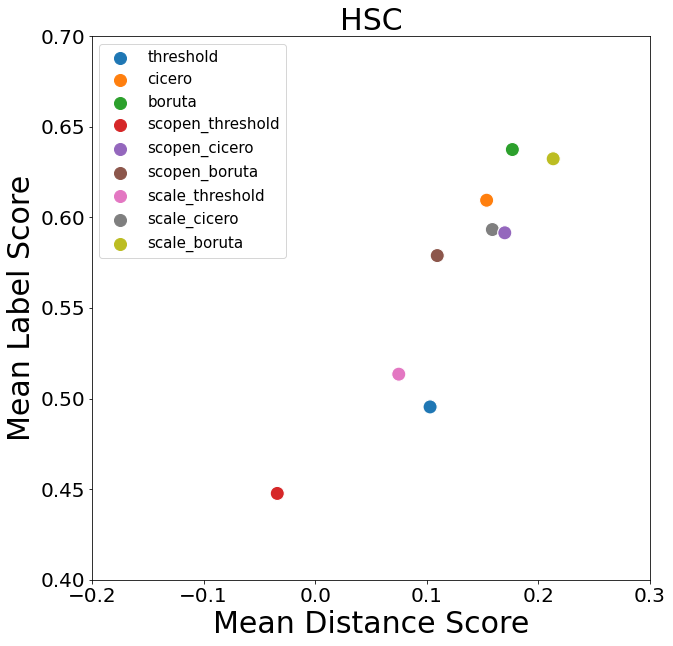

In [80]:
all_df_2, df_plotted_2 = process({
    'HSC_clustering': 'big'
}, output_fname='HSC.jpeg')

# Counting Correlation MLSI

In [84]:
from scipy.stats import pearsonr, kendalltau

In [85]:
pearsonr(df_plotted.mean_val_not_distance, df_plotted_2.mean_val_not_distance)

(0.7283968796640894, 0.02604364761777538)

In [86]:
df_plotted_2['ranks'] = [1571, 838, 2590, 685, 75, 2542, 744, -25, 0]
df_plotted['ranks'] = [1571, 838, 2590, 685, 75, 2542, 744, -25, 0]

In [87]:
pearsonr(df_plotted.mean_val_not_distance, df_plotted.ranks)

(0.9094481148000336, 0.000672684611148672)

In [88]:
pearsonr(df_plotted_2.mean_val_not_distance, df_plotted_2.ranks)

(0.7152329344132403, 0.030302484816265844)

In [89]:
pearsonr(df_plotted_2.mean_val_not_distance, df_plotted.mean_val_not_distance)

(0.7283968796640894, 0.02604364761777538)

In [90]:
kendalltau(df_plotted_2.mean_val_not_distance, df_plotted.mean_val_not_distance)

KendalltauResult(correlation=0.3888888888888889, pvalue=0.18018077601410934)

In [91]:
import seaborn as sns

In [92]:
df_plotted['diff'] = df_plotted['mean_val_not_distance'] - df_plotted.loc['threshold', 'mean_val_not_distance']

In [93]:
df_plotted_2['diff'] = df_plotted_2['mean_val_not_distance'] - df_plotted_2.loc['threshold', 'mean_val_not_distance']

In [94]:
df_plotted['diff']

method
boruta              0.040209
cicero              0.031226
scale_boruta        0.109267
scale_cicero        0.054283
scale_threshold     0.016315
scopen_boruta       0.115585
scopen_cicero       0.061207
scopen_threshold   -0.025832
threshold           0.000000
Name: diff, dtype: float64

In [95]:
df_plotted_2['mean_label_score'] = df_plotted['mean_val_not_distance']

In [96]:
df_plotted_2['improvement'] = df_plotted_2['mean_label_score'] - df_plotted_2.loc['threshold', 'mean_label_score']

/home/akhtyamovpavel/PythonEnvironments/BioInfoPython37/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]
/home/akhtyamovpavel/PythonEnvironments/BioInfoPython37/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


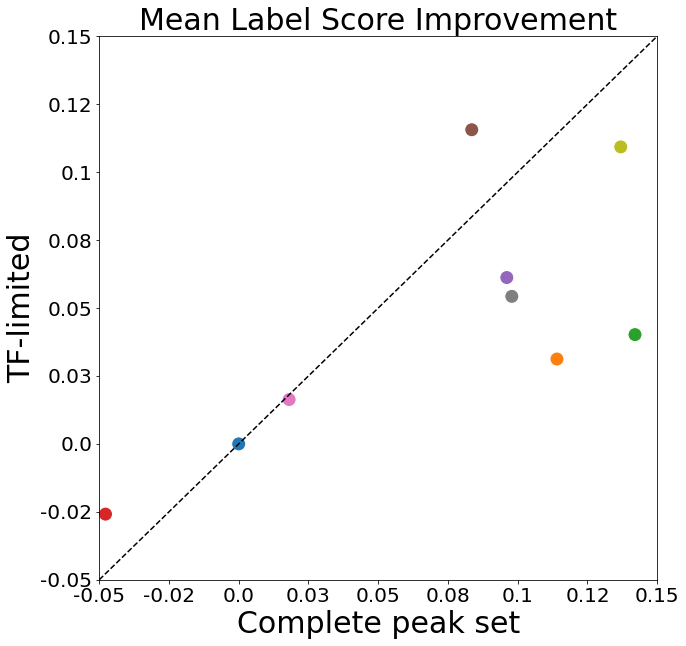

In [97]:
fig = plt.figure(figsize=(10, 10))
plot = sns.scatterplot(
    legend=None,
    data=df_plotted_2, x='diff', y='improvement', hue=df_plotted_2.index, 
               s=200,
            hue_order=['threshold', 'cicero', 'boruta', 'scopen_threshold',  'scopen_cicero', 'scopen_boruta', 'scale_threshold', 'scale_cicero', 'scale_boruta'])

plot.set_title('Mean Label Score Improvement', fontsize=30)
plot.set_xlim(-0.05, 0.15)
# plot.set_ylim(0.4, 0.65)
plot.set_ylim(-0.05, 0.15)
plt.plot(np.linspace(-0.05, 0.15, 1001), np.linspace(-0.05, 0.15, 1001), linestyle='dashed', color='black')
plot.set_xticklabels(plot.get_xticks().round(2), fontsize=20)
plot.set_yticklabels(plot.get_yticks().round(2), fontsize=20)
plot.set_ylabel('TF-limited', fontsize=30)
plot.set_xlabel('Complete peak set', fontsize=30)


# plot.legend(fontsize=15, markerscale=2, loc='lower right')
fig.savefig('../assets/ClusteringScatterplotMeanLabel.jpeg', bbox_inches='tight')

In [98]:
df_plotted_2

,mean_val_distance,mean_rank_distance,mean_val_not_distance,mean_rank_not_distance,dataset,clustering_type,ranks,diff,mean_label_score,improvement
method,,,,,,,,,,
boruta,0.176709,3.333333,0.637451,2.111111,HSC_clustering,150,1571,0.142043,0.501462,0.040209
cicero,0.153646,4.666667,0.609477,3.333333,HSC_clustering,150,838,0.114069,0.492478,0.031226
scale_boruta,0.213293,1.333333,0.632344,1.888889,HSC_clustering,150,2590,0.136936,0.570519,0.109267
scale_cicero,0.158789,4.333333,0.593298,4.000000,HSC_clustering,150,685,0.097890,0.515535,0.054283
scale_threshold,0.074934,7.000000,0.513480,7.222222,HSC_clustering,150,75,0.018072,0.477567,0.016315
scopen_boruta,0.109402,5.333333,0.578939,5.333333,HSC_clustering,150,2542,0.083531,0.576838,0.115585
scopen_cicero,0.169918,3.000000,0.591500,4.555556,HSC_clustering,150,744,0.096093,0.522459,0.061207
scopen_threshold,-0.033946,8.666667,0.447664,8.666667,HSC_clustering,150,-25,-0.047744,0.435420,-0.025832
threshold,0.102989,7.333333,0.495408,7.888889,HSC_clustering,150,0,0.000000,0.461252,0.000000


/home/akhtyamovpavel/PythonEnvironments/BioInfoPython37/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/home/akhtyamovpavel/PythonEnvironments/BioInfoPython37/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


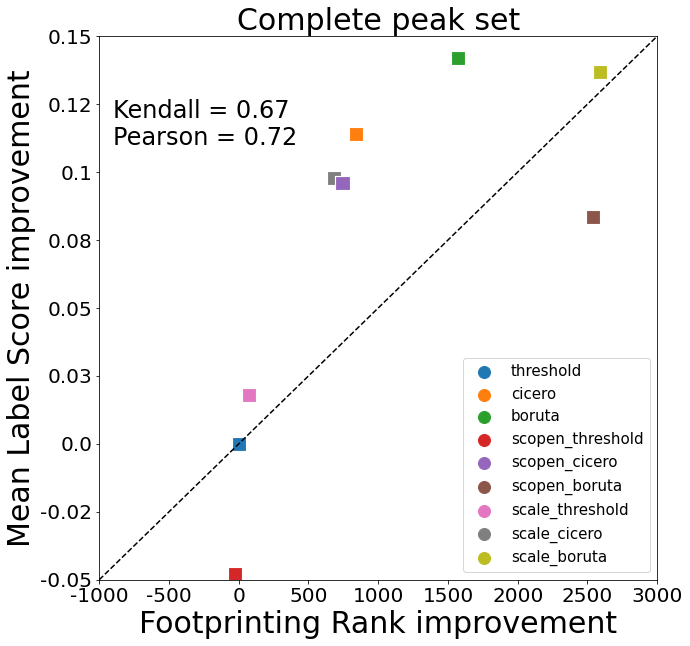

In [99]:
fig = plt.figure(figsize=(10, 10))
plot = sns.scatterplot(data=df_plotted_2, x='ranks', y='diff', hue=df_plotted_2.index, 
               s=200,
               marker='s',
            hue_order=['threshold', 'cicero', 'boruta', 'scopen_threshold',  'scopen_cicero', 'scopen_boruta', 'scale_threshold', 'scale_cicero', 'scale_boruta'])

plot.set_title('Complete peak set', fontsize=30)
plot.set_xlim(-1000, 3000)
plot.set_ylim(-0.05, 0.15)
plt.plot(np.linspace(-1000, 3000, 1001), np.linspace(-0.05, 0.15, 1001), linestyle='dashed', color='black')
plot.set_xticklabels(plot.get_xticks().astype(int), fontsize=20)
plot.set_yticklabels(plot.get_yticks().round(2), fontsize=20)
plot.set_ylabel('Mean Label Score improvement', fontsize=30)
plot.set_xlabel('Footprinting Rank improvement', fontsize=30)

plot.text(-900, 0.12, "Kendall = 0.67", fontsize=24)
plot.text(-900, 0.11, "Pearson = 0.72", fontsize=24)

plot.legend(fontsize=15, markerscale=2, loc='lower right')
fig.savefig('../assets/
            ClusteringScatterplotBefore.jpeg', bbox_inches='tight')

/home/akhtyamovpavel/PythonEnvironments/BioInfoPython37/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/home/akhtyamovpavel/PythonEnvironments/BioInfoPython37/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


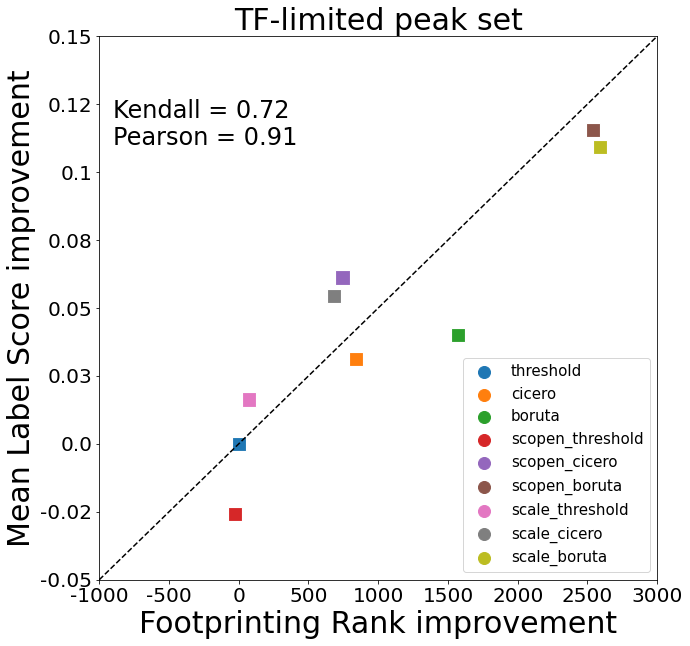

In [100]:
fig = plt.figure(figsize=(10, 10))
plot = sns.scatterplot(data=df_plotted, x='ranks', y='diff', hue=df_plotted_2.index, 
               s=200,
               marker='s',
            hue_order=['threshold', 'cicero', 'boruta', 'scopen_threshold',  'scopen_cicero', 'scopen_boruta', 'scale_threshold', 'scale_cicero', 'scale_boruta'])

plot.set_title('TF-limited peak set', fontsize=30)
plot.set_xlim(-1000, 3000)
plot.set_ylim(-0.05, 0.15)
plt.plot(np.linspace(-1000, 3000, 1001), np.linspace(-0.05, 0.15, 1001), linestyle='dashed', color='black')
plot.set_xticklabels(plot.get_xticks().astype(int), fontsize=20)
plot.set_yticklabels(plot.get_yticks().round(2), fontsize=20)
plot.set_ylabel('Mean Label Score improvement', fontsize=30)
plot.set_xlabel('Footprinting Rank improvement', fontsize=30)

plot.text(-900, 0.12, "Kendall = 0.72", fontsize=24)
plot.text(-900, 0.11, "Pearson = 0.91", fontsize=24)

plot.legend(fontsize=15, markerscale=2, loc='lower right')
fig.savefig('../assets/ClusteringScatterplot.jpeg', bbox_inches='tight')

In [101]:
df_plotted_2

,mean_val_distance,mean_rank_distance,mean_val_not_distance,mean_rank_not_distance,dataset,clustering_type,ranks,diff,mean_label_score,improvement
method,,,,,,,,,,
boruta,0.176709,3.333333,0.637451,2.111111,HSC_clustering,150,1571,0.142043,0.501462,0.040209
cicero,0.153646,4.666667,0.609477,3.333333,HSC_clustering,150,838,0.114069,0.492478,0.031226
scale_boruta,0.213293,1.333333,0.632344,1.888889,HSC_clustering,150,2590,0.136936,0.570519,0.109267
scale_cicero,0.158789,4.333333,0.593298,4.000000,HSC_clustering,150,685,0.097890,0.515535,0.054283
scale_threshold,0.074934,7.000000,0.513480,7.222222,HSC_clustering,150,75,0.018072,0.477567,0.016315
scopen_boruta,0.109402,5.333333,0.578939,5.333333,HSC_clustering,150,2542,0.083531,0.576838,0.115585
scopen_cicero,0.169918,3.000000,0.591500,4.555556,HSC_clustering,150,744,0.096093,0.522459,0.061207
scopen_threshold,-0.033946,8.666667,0.447664,8.666667,HSC_clustering,150,-25,-0.047744,0.435420,-0.025832
threshold,0.102989,7.333333,0.495408,7.888889,HSC_clustering,150,0,0.000000,0.461252,0.000000


/home/akhtyamovpavel/PythonEnvironments/BioInfoPython37/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
/home/akhtyamovpavel/PythonEnvironments/BioInfoPython37/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


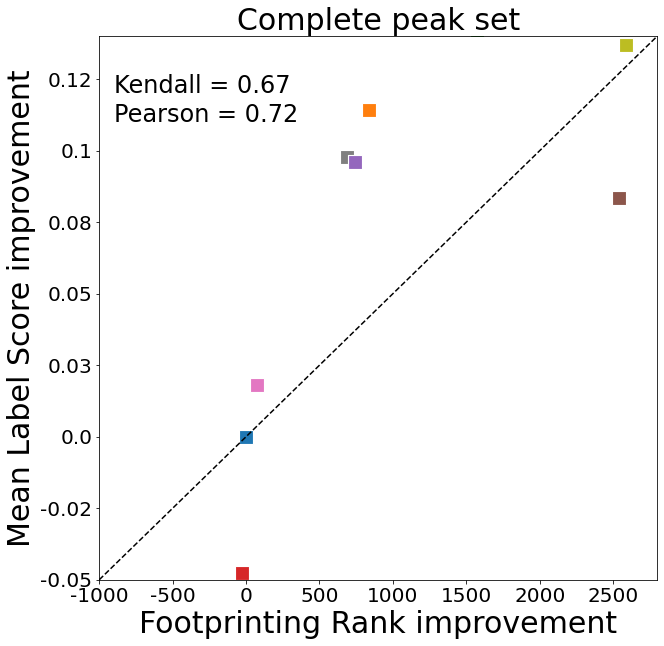

In [102]:
fig = plt.figure(figsize=(10, 10))
plot = sns.scatterplot(data=df_plotted_2, x='ranks', y='diff', hue=df_plotted_2.index, 
               s=200,
                       legend=None,
                       marker='s',
            hue_order=['threshold', 'cicero', 'boruta', 'scopen_threshold',  'scopen_cicero', 'scopen_boruta', 'scale_threshold', 'scale_cicero', 'scale_boruta'])

plot.set_title('Complete peak set', fontsize=30)
plot.set_xlim(-1000, 2800)
plot.set_ylim(-0.05, 0.14)
plt.plot(np.linspace(-1000, 2800, 1001), np.linspace(-0.05, 0.14, 1001), linestyle='dashed', color='black')
plot.set_xticklabels(plot.get_xticks().astype(int), fontsize=20)
plot.set_yticklabels(plot.get_yticks().round(2), fontsize=20)
plot.set_ylabel('Mean Label Score improvement', fontsize=30)
plot.set_xlabel('Footprinting Rank improvement', fontsize=30)
plot.text(-900, 0.12, "Kendall = 0.67", fontsize=24)
plot.text(-900, 0.11, "Pearson = 0.72", fontsize=24)
# plot.legend(fontsize=20, markerscale=2)
fig.savefig('../ClusteringScatterplotBefore.jpeg', bbox_inches='tight')

HSC_clustering/TopScaleThreshold.csv
HSC_clustering/TopScaleCicero.csv
HSC_clustering/Threshold.csv
HSC_clustering/Cicero.csv
HSC_clustering/TopScopenCicero.csv
HSC_clustering/TopScopenBoruta.csv
HSC_clustering/TopScopenThreshold.csv
HSC_clustering/TopScaleBoruta.csv
HSC_clustering/Boruta.csv
                 mean_val_distance  mean_rank_distance  mean_val_not_distance  \
method                                                                          
boruta                    0.176709            3.333333               0.637451   
cicero                    0.153646            4.666667               0.609477   
scale_boruta              0.213293            1.333333               0.632344   
scale_cicero              0.158789            4.333333               0.593298   
scale_threshold           0.074934            7.000000               0.513480   

                 mean_rank_not_distance  
method                                   
boruta                         2.111111  
cicero      

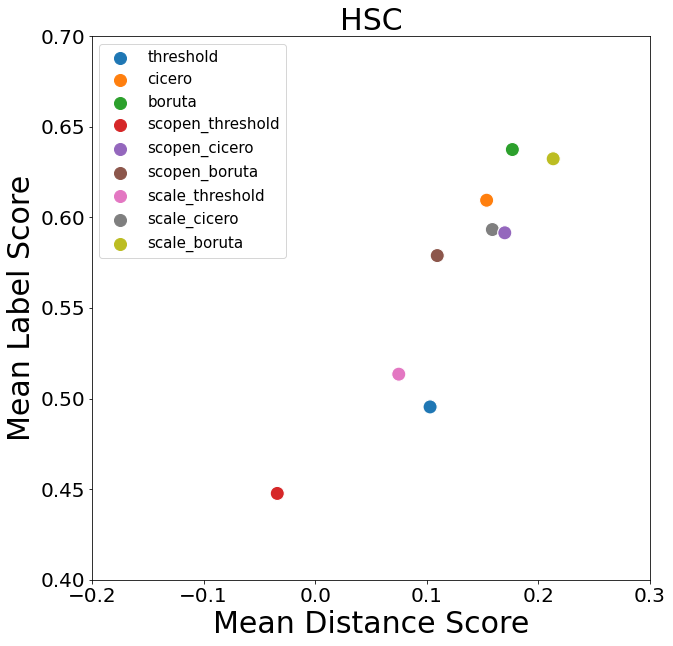

In [103]:
all_df_2, df_plotted_2 = process({
    'HSC_clustering': 'big'
}, output_fname='../assets/GSE96769.jpeg')

In [8]:
all_df.head()

,index,cols,vals,Metric,method,dtype,cell_dtype,rank
0,100000,distance_pca,0.383639,distance_pca,scale_boruta,big,small,4.0
1,100000,distance_tsne,0.576645,distance_tsne,scale_boruta,big,small,3.0
2,100000,distance_umap,0.691093,distance_umap,scale_boruta,big,small,4.0
3,100000,hc_ari,0.683209,hc_ari,scale_boruta,big,small,3.0
4,100000,hc_ami,0.791456,hc_ami,scale_boruta,big,small,4.0


## Drawing datasets Scatterplot (Fig. 2)

In [134]:
dataset_cell_mapping = {
    'GSE96769_TF': 'big',
    'FibroCard': 'big',
    'TCells': 'small',
    'CellLines': 'small',
    'PBMC5K': 'big',
    'HSC_clustering': 'small',
    'MouseAtlas': 'big',
    'Forebrain': 'small',
    'BreastTumor': 'small'
}

dataset_mapping = {
    'GSE96769_TF': 'big',
    'HSC_clustering': 'big',
    'FibroCard': 'small',
    'TCells': 'small',
    'CellLines': 'big',
    'PBMC5K': 'big',
    'HSC_clustering': 'big',
    'MouseAtlas': 'big',
    'Forebrain': 'small',
    'BreastTumor': 'small'
}

named_titles = {
    'GSE96769_TF': 'TF-limited Clustering Score',
    'HSC_clustering': 'Complete Clustering Scores',
    'TCells': 'small',
    'CellLines': 'small',
    'PBMC5K': 'big',
    'HSC_clustering': 'small',
    'MouseAtlas': 'Mouse Atlas',
    'Forebrain': 'small',
    'FibroCard': 'FibroCard',
}

named_titles = {
    'GSE96769_TF': 'TF-limited Clustering Score',
    'HSC_clustering': 'HSC',
    'TCells': 'TCells',
    'CellLines': 'CellLines',
    'PBMC5K': 'PBMC5K',
    'HSC_clustering': 'HSC',
    'MouseAtlas': 'Mouse Atlas',
    'Forebrain': 'Forebrain',
    'FibroCard': 'FibroCard',
    'BreastTumor': 'BreastTumor'
}

clustering_method = {
    'CellLines': '150',
    'TCells': '150',
    'Forebrain': '150',
    'BreastTumor': '150',
    'GSE96769_TF': '150',
    'HSC_clustering': '150',
    'PBMC5K': '150',
    'MouseAtlas': '150',
    'FibroCard': '150',
#     'GSE96769/TopMetricsFull': 'all'
}

In [141]:
all_df

,index,cols,vals,Metric,method,dtype,cell_dtype,clustering_type,rank
0,100000,distance_pca,0.383639,distance_pca,scale_boruta,large,small,150,4.0
1,100000,distance_tsne,0.576645,distance_tsne,scale_boruta,large,small,150,3.0
2,100000,distance_umap,0.691093,distance_umap,scale_boruta,large,small,150,4.0
3,100000,hc_ari,0.683209,hc_ari,scale_boruta,large,small,150,3.0
4,100000,hc_ami,0.791456,hc_ami,scale_boruta,large,small,150,4.0
...,...,...,...,...,...,...,...,...,...
7,0.4,kmeans_ami,0.513103,kmeans_ami,scopen_cicero,small,small,150,4.0
8,0.4,kmeans_homogeneity,0.490333,kmeans_homogeneity,scopen_cicero,small,small,150,4.0
9,0.4,louvain_ari,0.401431,louvain_ari,scopen_cicero,small,small,150,7.0
10,0.4,louvain_ami,0.532229,louvain_ami,scopen_cicero,small,small,150,4.0


In [ ]:
## Drawing per metric

all_df, _ = process(['CellLines', 'PBMC5K', 'MouseAtlas', 'HSC_clustering', 'FibroCard', 'Forebrain', 'TCells'])

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20 * 3, 20 * 4))


all_df.loc[all_df.dtype == 'big', 'dtype'] = 'large'

mapping = ['Silhouette Score', 'Hierarhical Clustering', 'KMeans', 'Louvain']
for index, metric in enumerate(sorted(all_df.Metric.unique())):
    
    col = index % 3
    row = index // 3
    
    
    subset_df = all_df[all_df.Metric == metric]
    
    plot = sns.boxplot(
        data=subset_df, y='vals', x='method',
        hue='dtype',
        ax=ax[row, col],
        order=['threshold', 'cicero', 'boruta', 'scopen_threshold',  'scopen_cicero', 'scopen_boruta', 'scale_threshold', 'scale_cicero', 'scale_boruta'],
        hue_order=['large', 'small'],
    
    )
    
    if metric.startswith('distance'):
        metric = metric.replace('distance', 'silhouette')
    
    letter = chr(ord('a') + index)
    plot.text(-2, 0.9, letter, 
       fontsize = 120,          # Size
       color = "black",          # Color
       ha = "center", # Horizontal alignment
       va = "center")
    
    plot.set_xlabel(f'', fontsize=50)
    if row >= 1:
        plot.set_ylim((0.0, 1.0))
    else:
        plot.set_ylim((-0.5, 1.0))
    
    if row == 0:
        plot.set_title(f'{metric.split("_", 1)[1]}', fontsize=50)
        plot.set_ylabel(mapping[row], fontsize=50)
    else:
        plot.set_ylabel(f'{metric.split("_", 1)[1]}', fontsize=50)
        plot.set_title(mapping[row], fontsize=50)
        
    
    current_ax = ax[row, col]
    current_ax.set_xticklabels(current_ax.get_xticklabels(),rotation=45)
    ax[row, col].tick_params(labelsize=50)

plt.subplots_adjust(left=0.02,
                bottom=0.02,
                right=0.98,
                top=0.98,
                wspace=0.47,
                hspace=0.47)
    
plt.savefig(f'../assets/ByMetricBoxplotVariantPeakAll.jpeg', bbox_inches='tight')

In [143]:
all_df.Metric.unique()

array(['distance_pca', 'distance_tsne', 'distance_umap', 'hc_ari',
       'hc_ami', 'hc_homogeneity', 'kmeans_ari', 'kmeans_ami',
       'kmeans_homogeneity', 'louvain_ari', 'louvain_ami',
       'louvain_homogeneity'], dtype=object)

## Drawing representative features

In [139]:
metrics = ['distance_umap', 'hc_ari', 'louvain_ari']

In [140]:
all_df

,index,cols,vals,Metric,method,dtype,cell_dtype,clustering_type,rank
0,100000,distance_pca,0.383639,distance_pca,scale_boruta,large,small,150,4.0
1,100000,distance_tsne,0.576645,distance_tsne,scale_boruta,large,small,150,3.0
2,100000,distance_umap,0.691093,distance_umap,scale_boruta,large,small,150,4.0
3,100000,hc_ari,0.683209,hc_ari,scale_boruta,large,small,150,3.0
4,100000,hc_ami,0.791456,hc_ami,scale_boruta,large,small,150,4.0
...,...,...,...,...,...,...,...,...,...
7,0.4,kmeans_ami,0.513103,kmeans_ami,scopen_cicero,small,small,150,4.0
8,0.4,kmeans_homogeneity,0.490333,kmeans_homogeneity,scopen_cicero,small,small,150,4.0
9,0.4,louvain_ari,0.401431,louvain_ari,scopen_cicero,small,small,150,7.0
10,0.4,louvain_ami,0.532229,louvain_ami,scopen_cicero,small,small,150,4.0


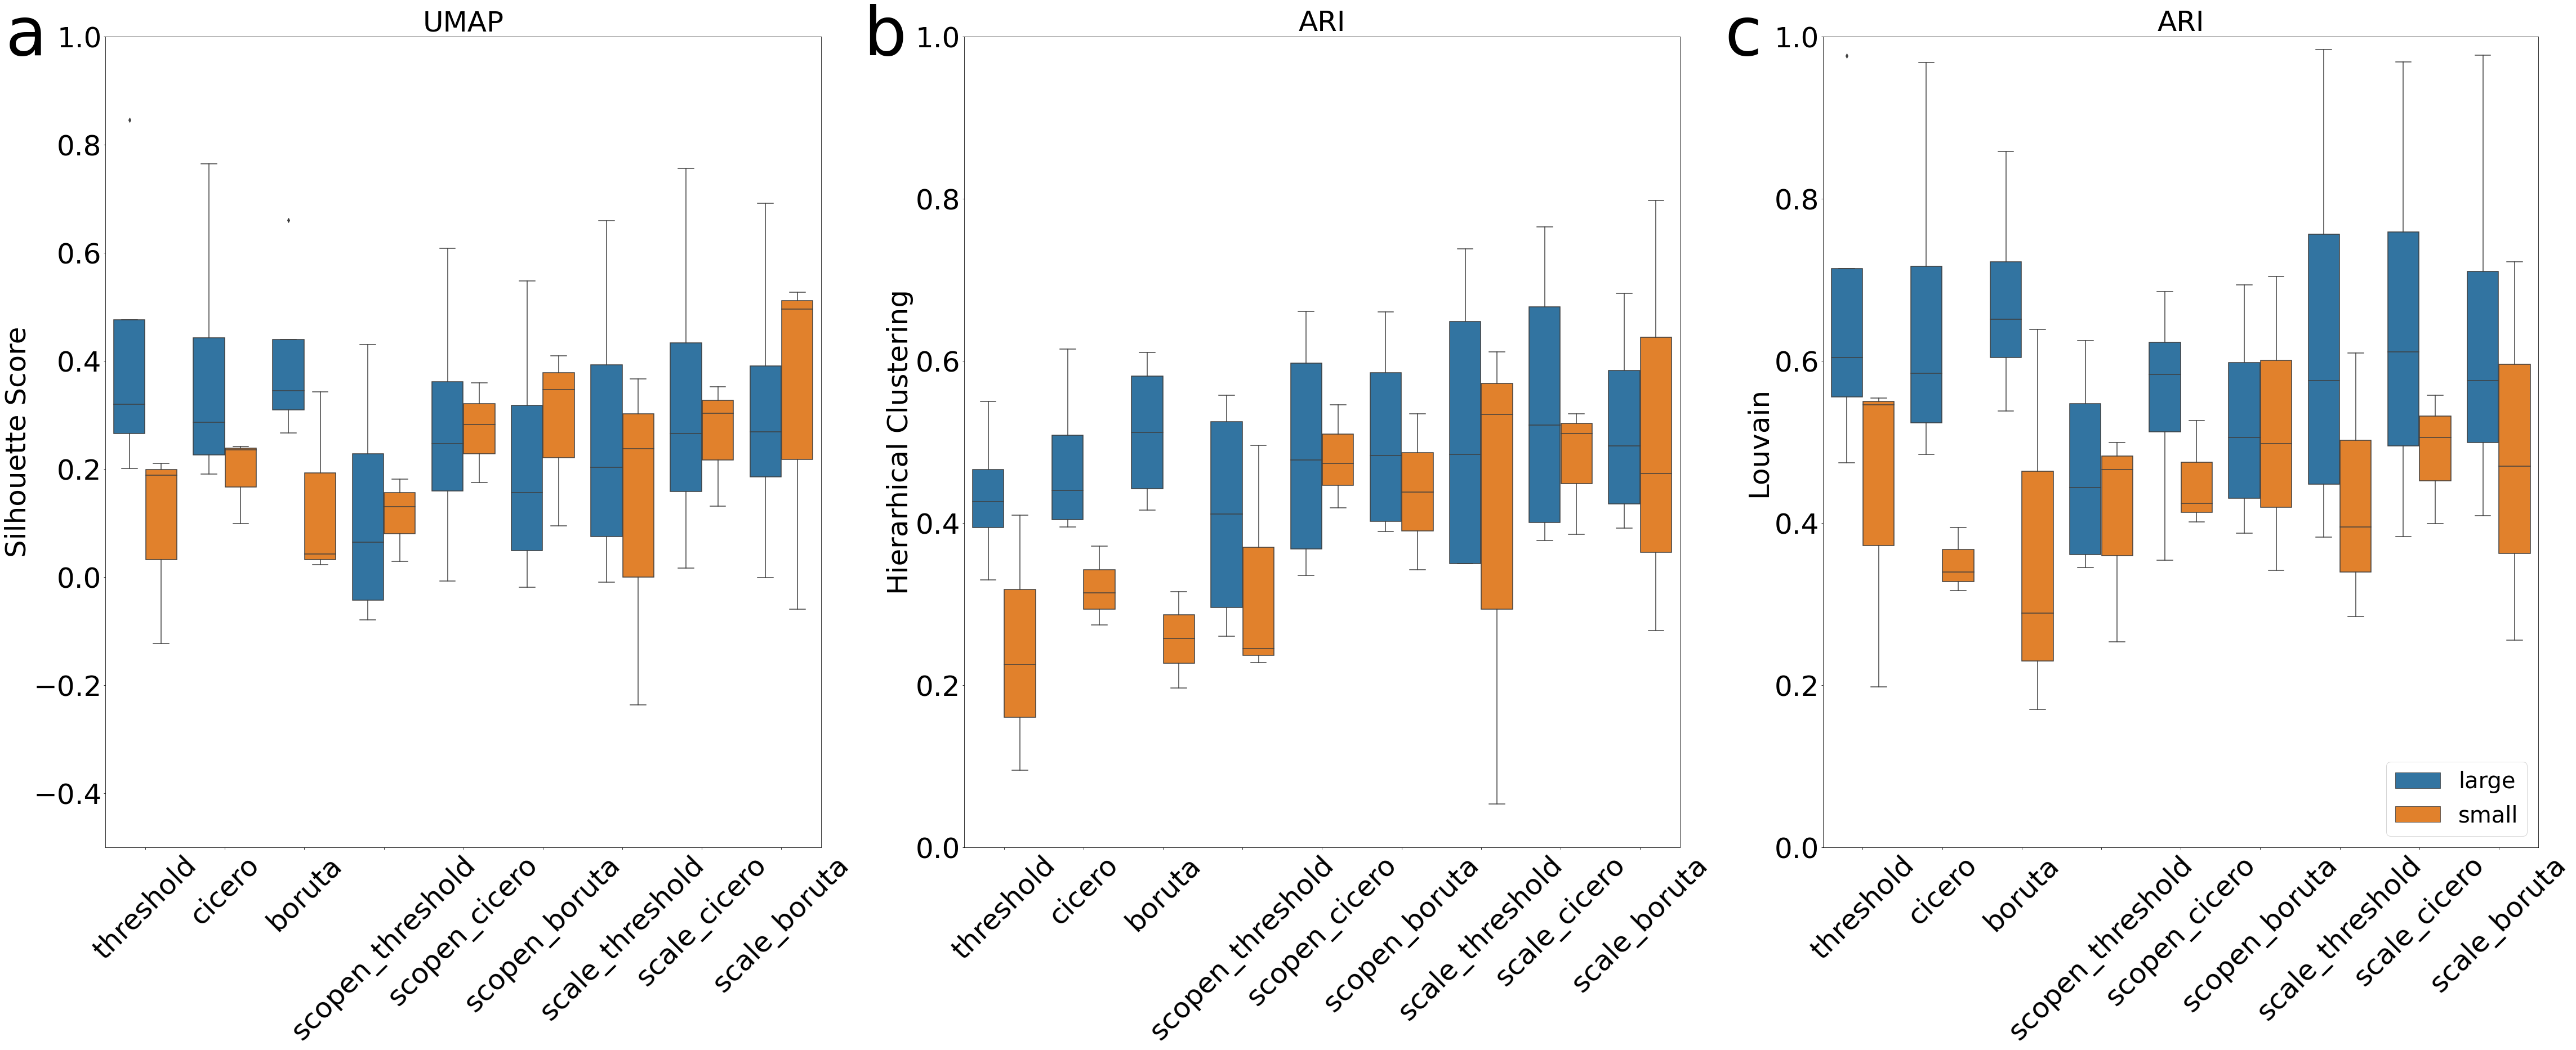

In [149]:



fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20 * 3, 20))

mapping = ['Silhouette Score', 'Hierarhical Clustering', 'KMeans', 'Louvain']
for index, metric in enumerate(metrics):
    
    col = index % 3
    
    
    subset_df = all_df[all_df.Metric == metric]
    
    plot = sns.boxplot(
        data=subset_df, y='vals', x='method',
        hue='dtype',
        ax=ax[col],
        order=['threshold', 'cicero', 'boruta', 'scopen_threshold',  'scopen_cicero', 'scopen_boruta', 'scale_threshold', 'scale_cicero', 'scale_boruta'],
        hue_order=['large', 'small'],
    
    )
    
    if metric.startswith('distance'):
        metric = metric.replace('distance', 'silhouette')
    
    letter = chr(ord('a') + index)
    plot.text(-1.5, 1.0, letter, 
       fontsize = 120,          # Size
       color = "black",          # Color
       ha = "center", # Horizontal alignment
       va = "center")
    
    plot.set_xlabel(f'', fontsize=50)
    if col == 0:
        plot.set_ylim((-0.5, 1.0))
    else:
        plot.set_ylim((0.0, 1.0))
        
    if col == 0:
        plot.set_title('UMAP', fontsize=50)
        plot.set_ylabel('Silhouette Score', fontsize=50)
    elif col == 1:
        plot.set_title('ARI', fontsize=50)
        plot.set_ylabel('Hierarhical Clustering', fontsize=50)
    else:
        plot.set_title('ARI', fontsize=50)
        plot.set_ylabel('Louvain', fontsize=50)
    
    if col < 2:
        plot.get_legend().remove()
    else:
        plot.legend(fontsize=40, loc='lower right')
        
    
    current_ax = ax[col]
    current_ax.set_xticklabels(current_ax.get_xticklabels(),rotation=45)
    ax[col].tick_params(labelsize=50)


plt.subplots_adjust(left=0.0,
                bottom=0.0,
                right=1.0,
                top=1.0,
                wspace=0.2,
                hspace=0.2)
    
plt.savefig(f'../assets/ByMetricSubset.jpeg', bbox_inches='tight')